In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import IntegerComparator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI
import matplotlib.pyplot as plt

import math

# パラメータの設定

In [2]:
num = 4 #株の数（もしくは変動日数）
theta = math.pi/2 #株の上下変動のしやすさ

# 元となる量子状態

In [3]:
qc = QuantumCircuit(num)

for i in range(num):
    qc.ry(theta,i)

qc.draw()

┌─────────┐
q_0: ┤ Ry(π/2) ├
     ├─────────┤
q_1: ┤ Ry(π/2) ├
     ├─────────┤
q_2: ┤ Ry(π/2) ├
     ├─────────┤
q_3: ┤ Ry(π/2) ├
     └─────────┘

In [4]:
qc_measure = qc.measure_all(inplace=False)

sampler = Sampler()
job = sampler.run(qc_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [5]:
qubit_state = []

for i, prob in binary_probabilities.items():
    print(i,prob)
    qubit_state.append([i,prob])

qubit_state.sort()

1010 0.0634765625
0101 0.0634765625
0110 0.0634765625
1011 0.0673828125
1100 0.0576171875
0100 0.0537109375
1001 0.076171875
1111 0.048828125
1101 0.0712890625
1000 0.0537109375
1110 0.060546875
0001 0.05859375
0011 0.064453125
0111 0.0751953125
0010 0.060546875
0000 0.0615234375


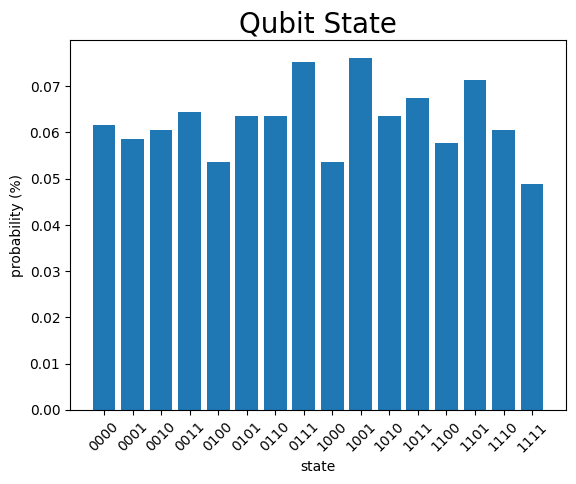

In [6]:
# plot probabilities of each states
q_state = []
q_prob = []
for state in qubit_state:
    q_state.append(state[0])
    q_prob.append(state[1])

plt.bar(q_state,q_prob)
#plt.legend(fontsize=15)
plt.xlabel("state", size=10)
plt.ylabel("probability (%)", size=10)
plt.title("Qubit State", size=20)
plt.xticks(size=10,rotation=45)
plt.yticks(size=10)
plt.show()

# 変動分の足し合わせ

In [15]:
from qiskit.circuit.library import WeightedAdder
from qiskit.circuit.library import LinearAmplitudeFunction

agg = WeightedAdder(num, [1] * num)

qr_state = QuantumRegister(qc.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
cr = ClassicalRegister(agg.num_sum_qubits, "value")

L_sum_state = QuantumCircuit(qr_state, qr_sum, qr_carry, cr)

# load the variable
L_sum_state.append(qc.to_gate(), qr_state)

# aggregate
L_sum_state.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

L_sum_state.measure(qr_sum[:],cr[:])

L_sum_state.draw()

┌──────────────┐┌────────┐         
state_0: ┤0             ├┤0       ├─────────
         │              ││        │         
state_1: ┤1             ├┤1       ├─────────
         │  circuit-158 ││        │         
state_2: ┤2             ├┤2       ├─────────
         │              ││        │         
state_3: ┤3             ├┤3       ├─────────
         └──────────────┘│        │┌─┐      
  sum_0: ────────────────┤4       ├┤M├──────
                         │  adder │└╥┘┌─┐   
  sum_1: ────────────────┤5       ├─╫─┤M├───
                         │        │ ║ └╥┘┌─┐
  sum_2: ────────────────┤6       ├─╫──╫─┤M├
                         │        │ ║  ║ └╥┘
carry_0: ────────────────┤7       ├─╫──╫──╫─
                         │        │ ║  ║  ║ 
carry_1: ────────────────┤8       ├─╫──╫──╫─
                         │        │ ║  ║  ║ 
carry_2: ────────────────┤9       ├─╫──╫──╫─
                         └────────┘ ║  ║  ║ 
value: 3/═══════════════════════════╩══╩══╩═
                                    0  1  2

In [16]:
sampler = Sampler()
job = sampler.run(L_sum_state)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [17]:
qubit_state_L = []

for i, prob in binary_probabilities.items():
    print(i,prob)
    qubit_state_L.append([i,prob])

qubit_state_L.sort()

100 0.0537109375
001 0.25390625
011 0.271484375
000 0.0634765625
010 0.357421875


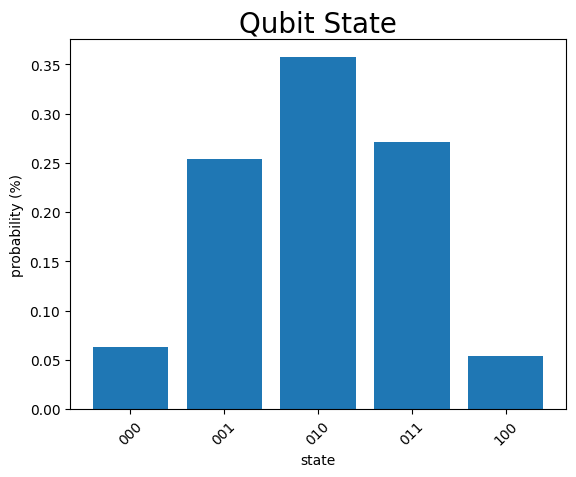

In [18]:
# plot probabilities of each states
q_state_L = []
q_prob_L = []
for state in qubit_state_L:
    q_state_L.append(state[0])
    q_prob_L.append(state[1])

plt.bar(q_state_L,q_prob_L)
#plt.legend(fontsize=15)
plt.xlabel("state", size=10)
plt.ylabel("probability (%)", size=10)
plt.title("Qubit State", size=20)
plt.xticks(size=10,rotation=45)
plt.yticks(size=10)
plt.show()

# 量子位相推定によるLの推定

In [11]:
# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum([1]*num)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [12]:
# define the registers for convenience and readability
qr_state = QuantumRegister(qc.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
qr_obj = QuantumRegister(1, "objective")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

# load the random variable
state_preparation.append(qc.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

# draw the circuit
state_preparation.draw()

┌──────────────┐┌────────┐      ┌───────────┐
  state_0: ┤0             ├┤0       ├──────┤0          ├
           │              ││        │      │           │
  state_1: ┤1             ├┤1       ├──────┤1          ├
           │  circuit-158 ││        │      │           │
  state_2: ┤2             ├┤2       ├──────┤2          ├
           │              ││        │      │           │
  state_3: ┤3             ├┤3       ├──────┤3          ├
           └──────────────┘│        │┌────┐│           │
objective: ────────────────┤        ├┤3   ├┤           ├
                           │        ││    ││           │
    sum_0: ────────────────┤4 adder ├┤0   ├┤4 adder_dg ├
                           │        ││  F ││           │
    sum_1: ────────────────┤5       ├┤1   ├┤5          ├
                           │        ││    ││           │
    sum_2: ────────────────┤6       ├┤2   ├┤6          ├
                           │        │└────┘│           │
  carry_0: ────────────────┤7       ├──────┤7          ├
                           │        │      │           │
  carry_1: ────────────────┤8       ├──────┤8          ├
                           │        │      │           │
  carry_2: ────────────────┤9       ├──────┤9          ├
                           └────────┘      └───────────┘

In [13]:
epsilon = 0.01
alpha = 0.1

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result = ae.estimate(problem)

In [14]:
print(result.estimation_processed)

2.01343163913194


# 量子位相推定によるVaR推定

In [19]:
# set x value to estimate the CDF
x_eval = 1

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
comparator.draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │      │
state_2: ┤2     ├
         │  cmp │
compare: ┤3     ├
         │      │
  a21_0: ┤4     ├
         │      │
  a21_1: ┤5     ├
         └──────┘

In [21]:
def get_cdf_circuit(x_eval):
    # define the registers for convenience and readability
    qr_state = QuantumRegister(qc.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
    qr_obj = QuantumRegister(1, "objective")
    qr_compare = QuantumRegister(1, "compare")

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

    # load the random variable
    state_preparation.append(qc, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

    # comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:-1])

    # uncompute aggregation
    state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

    return state_preparation


state_preparation = get_cdf_circuit(x_eval)
state_preparation.draw()

┌──────────────┐┌────────┐        ┌───────────┐
  state_0: ┤0             ├┤0       ├────────┤0          ├
           │              ││        │        │           │
  state_1: ┤1             ├┤1       ├────────┤1          ├
           │  circuit-158 ││        │        │           │
  state_2: ┤2             ├┤2       ├────────┤2          ├
           │              ││        │        │           │
  state_3: ┤3             ├┤3       ├────────┤3          ├
           └──────────────┘│        │┌──────┐│           │
objective: ────────────────┤        ├┤3     ├┤           ├
                           │        ││      ││           │
    sum_0: ────────────────┤4 adder ├┤0     ├┤4 adder_dg ├
                           │        ││      ││           │
    sum_1: ────────────────┤5       ├┤1     ├┤5          ├
                           │        ││  cmp ││           │
    sum_2: ────────────────┤6       ├┤2     ├┤6          ├
                           │        ││      ││           │
  carry_0: ────────────────┤7       ├┤4     ├┤7          ├
                           │        ││      ││           │
  carry_1: ────────────────┤8       ├┤5     ├┤8          ├
                           │        │└──────┘│           │
  carry_2: ────────────────┤9       ├────────┤9          ├
                           └────────┘        └───────────┘

In [22]:
# set target precision and confidence level
epsilon = 0.01

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation
ae_cdf = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result_cdf = ae_cdf.estimate(problem)

In [23]:
def run_ae_for_cdf(x_eval, epsilon=0.01, alpha=0.05):

    # construct amplitude estimation
    state_preparation = get_cdf_circuit(x_eval)
    problem = EstimationProblem(
        state_preparation=state_preparation, objective_qubits=[len(qr_state)]
    )
    ae_var = IterativeAmplitudeEstimation(
        epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
    )
    result_var = ae_var.estimate(problem)

    return result_var.estimation

In [24]:
def bisection_search(
    objective, target_value, low_level, high_level, low_value=None, high_value=None
):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print("--------------------------------------------------------------------")
    print("start bisection search for target value %.3f" % target_value)
    print("--------------------------------------------------------------------")
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "success"}

    # check if high_value is above target
    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    # perform bisection search until
    print("low_level    low_value    level    value    high_level    high_value")
    print("--------------------------------------------------------------------")
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print(
            "%2d           %.3f        %2d       %.3f    %2d            %.3f"
            % (low_level, low_value, level, value, high_level, high_value)
        )

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print("--------------------------------------------------------------------")
    print("finished bisection search")
    print("--------------------------------------------------------------------")
    return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}

In [27]:
losses = [0,5]

# run bisection search to determine VaR
objective = lambda x: run_ae_for_cdf(x)
bisection_result = bisection_search(
    objective, 1 - alpha, min(losses), max(losses), low_value=0, high_value=1
)
var = bisection_result["level"]

--------------------------------------------------------------------
start bisection search for target value 0.900
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
 0           0.000         2       0.686     5            1.000
 2           0.686         4       1.000     5            1.000
 2           0.686         3       0.937     4            1.000
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------


In [28]:
print("Estimated Value at Risk: %2d" % var)
print("Estimated Probability:    %.3f" % bisection_result["value"])

Estimated Value at Risk:  3
Estimated Probability:    0.937
